# Snake

This notebook demonstrates the iterative process taken to develop a model capable of playing snake quite effectively.

I am currently training an even better model than the one that can be seen at the bottom of this notebook.

## Instructions to run

Feel free to run all cells in order, there is no model training that will occur by doing this. 

Cells responsible for model training are commented out for the purpose of observing the code for interested individuals.

In [1]:
import os
import pandas as pd
import time
import numpy as np

In [2]:
from definitions import ROOT

from snake.environment.game_environment import (
    BaseSnakeEnv, 
)
from callbacks.callbacks import ScoreLoggerCallback
from evaluation.evaluation import get_performance, produce_plots, watch_agent_play
from snake.visualisation.state_visualisation import visualise_game_state

from stable_baselines3 import DQN

## Explaining the environment

Stable baselines 3 (SB3) allows users to define a custom environment. Please see the class implementation in src/snake/environment/game_environment for more details. I chose to build my own environment because it allowed me the most flexibility.


The state space seen by the snake is a 1-d array of length 100 representing a 10x10 grid. Each value is 0,1,2,3

0 - empty

1 - food

2 - tail

3 - head

### Run the below cell to see the environment for yourself

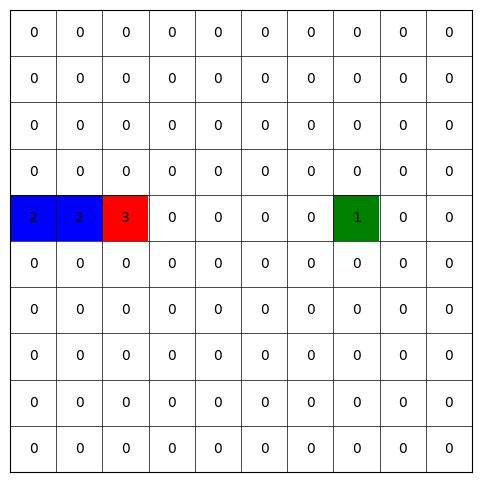

In [3]:
env = BaseSnakeEnv()
env.reset()

visualise_game_state(env.state)

## First benchmark

This first model uses the SB3 default DQN multi-layer perceptron model.

There is an input layer with 400 neurons. Each feature is a binary variable representing the presence or absence of each value 0,1,2,3 for each coordinate location.

There are two fully-connected hidden layers with 64 neurons each and have ReLU activation. 

The final layer is 3 neurons that represent the three actions.


The reward function is as follows:

$$
R(a, s) = 
\begin{cases} 
1, & \text{if food is eaten in state } s \text{ after action } a, \\
-1, & \text{if snake hits wall / own tail in state} s \text{ after action } a, \\
0, & \text{otherwise.}
\end{cases}
$$

i train with 100_000 environment interactions to get a benchmark with about 5 minutes of training.

In [4]:
#env = BaseSnakeEnv()

#model_dqn = DQN("MlpPolicy", env=env)


#start_time = time.time()
#score_logger = ScoreLoggerCallback()
#model_dqn.learn(total_timesteps=100000, callback=score_logger)
#metrics_dqn_first_benchmark = score_logger.get_metrics()
#print(time.time() - start_time)

In [5]:
model_dqn = DQN.load(os.path.join(ROOT, "../models/dqn_first_benchmark"))
metrics_dqn_first_benchmark = pd.read_csv(os.path.join(ROOT, "../data/training_metrics/base_dqn.csv"))

/Users/danielbibby/Library/Caches/pypoetry/virtualenvs/snake-wdU-voMb-py3.11/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Users/danielbibby/Library/Caches/pypoetry/virtualenvs/snake-wdU-voMb-py3.11/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


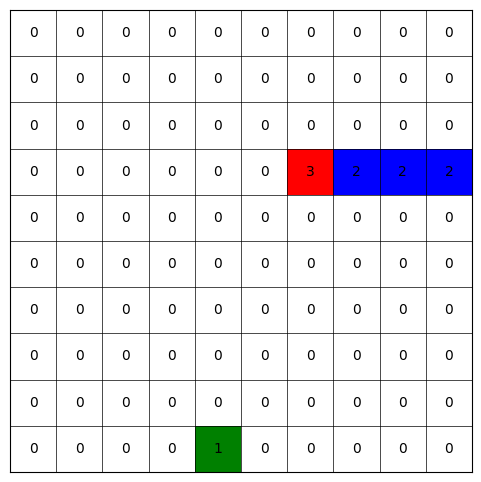

In [ ]:
# interrupt kernel to stop rendering. Otherwise, rendering will stop after num_timesteps actions.
watch_agent_play(model = model_dqn, env = BaseSnakeEnv(), num_timesteps=100)

In [ ]:
produce_plots(metrics_dqn_first_benchmark)

### Takeaways

This agent is pretty rubbish at finding food, but actually quite good at avoiding walls which can be seen from the average game length and average score. 

This example demonstrates the setup facilitates learning for an agent and acts as a foundation to build on.

## Taking advantage of rotational symmetry

Observe the below states. Hopefully you aggree that they are actually the same, or at least the same logic should be applied to a decision.

In [ ]:
def fill_board(info):
    state = [0] * 100
    
    for i in info[:-1]:
        state[i] = 2
    state[info[-2]] = 3
    state[info[-1]] = 1
        
    return state

state1 = [0, 1, 2, 5]
state2 = [9, 19, 29, 59]
state3 = [99, 98, 97,94]
state4 = [90, 80, 70, 40]

visualise_game_state(fill_board(state1))
visualise_game_state(fill_board(state2))
visualise_game_state(fill_board(state3))
visualise_game_state(fill_board(state4))

In this section I take advantage of this rotational symetry by rotating the state representation so the agent is alwyas moving upwards. Observing the enviornment would be impossible for humans but allows the agent to process rotationally symmetric states in the same logic.

Using the same training structure as in the first benchmark, let's observe the difference in resutls.

In [ ]:
from snake.environment.game_environment import SnakeEnvRotatedState

In [ ]:
#env = SnakeEnvRotatedState()

#model_dqn_rotated_state = DQN("MlpPolicy", env=env)


#start_time = time.time()

#score_logger = ScoreLoggerCallback()
#model_dqn_rotated_state.learn(total_timesteps=100000, callback=score_logger)
#metrics_dqn_rotated_state = score_logger.get_metrics()

#print(time.time() - start_time)

In [ ]:
model_dqn_rotated_state = DQN.load(os.path.join(ROOT, "../models/dqn_rotated_state"))
metrics_dqn_rotated_state = pd.read_csv(os.path.join(ROOT, "../data/training_metrics/rotated_state_dqn.csv"))

In [ ]:
# interrupt kernel to stop rendering, ohterwise rendering will end after 100 steps
watch_agent_play(model_dqn_rotated_state, env = SnakeEnvRotatedState(), num_timesteps=100)

In [ ]:
produce_plots(metrics_dqn_rotated_state)

### Takeaways

Observing the average score plot, the an average score of approx 1.2 is acheived in about 25_000 training steps, 1/4 the time taken from the first benchmark. This is representative of the efficiency gain from this rotation. 

I will leave the state space representation the same from now on but wanted to demonstrate the gains that can be made by thinking about each part of the RL framework and how they can be optimised.

## Reward Engineering 1

Right now, the agent is very poor at actually finding food. This is a common problem in RL problems where the reward comes after a sometimes long sequence of steps. Think of a terminator tasked with protecting John Connor, Arnold Schwarzenegger doesn't know until the end of the movie that this task was a success. 

To tackle this problem in my setting, I first introduce a smaller reward for making movements towards food.

$$
R(a, s) = 
\begin{cases} 
1, & \text{if food is eaten in state } s \text{ after action } a, \\
-1, & \text{if snake hits wall / own tail in state} s \text{ after action } a, \\
0.2, & \text{if snake moved towards food after action } a, \\
-0.2, & \text{if snake moved away from food after action } a, \\
0, & \text{otherwise.}
\end{cases}
$$

I also use the newly rotated states and compare now to the more successful model above.

In [ ]:
from snake.environment.game_environment import SnakeEnvRandS

In [ ]:
#env = SnakeEnvRandS()

#model_dqn_new_reward = DQN("MlpPolicy", env=env)


#start_time = time.time()

#score_logger = ScoreLoggerCallback()
#model_dqn_new_reward.learn(total_timesteps=100000, callback=score_logger)
#metrics_dqn_new_reward = score_logger.get_metrics()

#print(time.time() - start_time)

In [ ]:
model_dqn_new_reward = DQN.load(os.path.join(ROOT, "../models/dqn_new_reward"))
metrics_dqn_new_reward = pd.read_csv(os.path.join(ROOT, "../data/training_metrics/new_reward_dqn.csv"))



In [ ]:
produce_plots(metrics_dqn_new_reward)

### Takeaway

Observe two key things here
1. Higher average score
2. Shorter average games

So the agent is finding food far more reliably now. However, consider how this agent might behave with a very long tail, in this situation it woul dbe better to move towards food slowly and safely rather than directly. Although, this is a good start for now.

## Bias reduction

In my currecnt approach the game is always reset to the same position. This leads to a high proportion of training data coming from the same state observations, leading to a model that is over trained on a small subset of states. Furthermore, there is an overly high proportion of training data where the snake is quite short. 

To combat this I implemented a random reset method so that, during training, the agent is reset to a random position. 

**Coil reset** - pick a random spot and a snake length then take a random walk towards the tail until max length  is reached or the tail is trapped.

**Line reset** - pick a random snake length and draw a straight line in some direction of that length.

Visualise the two below.

In [ ]:
from snake.environment.game_environment import SnakeEnvLineReset, SnakeEnvCoilReset

In [ ]:
env = SnakeEnvCoilReset()

np.random.seed(41)
state, _ = env.reset()

visualise_game_state(state)

In [ ]:
env = SnakeEnvLineReset()

np.random.seed(41)
state, _ = env.reset()

visualise_game_state(state)

In [ ]:
#env = SnakeEnvCoilReset()

#model_dqn_coil_reset = DQN("MlpPolicy", env=env)


#start_time = time.time()

#score_logger = ScoreLoggerCallback()
#model_dqn_coil_reset.learn(total_timesteps=100000, callback=score_logger)
#metrics_dqn_coil_reset = score_logger.get_metrics()

#print(time.time() - start_time)

In [ ]:
#env = SnakeEnvLineReset()

#model_dqn_line_reset = DQN("MlpPolicy", env=env)


#start_time = time.time()

#score_logger = ScoreLoggerCallback()
#model_dqn_line_reset.learn(total_timesteps=100000, callback=score_logger)
#metrics_dqn_line_reset = score_logger.get_metrics()

#print(time.time() - start_time)

In [ ]:
model_dqn_coil_reset = DQN.load(os.path.join(ROOT, "../models/dqn_coil_reset"))
metrics_dqn_coil_reset = pd.read_csv(os.path.join(ROOT, "../data/training_metrics/coil_reset_dqn.csv"))

model_dqn_line_reset = DQN.load(os.path.join(ROOT, "../models/dqn_line_reset"))
metrics_dqn_line_reset = pd.read_csv(os.path.join(ROOT, "../data/training_metrics/line_reset_dqn.csv"))


In [ ]:
produce_plots(metrics_dqn_coil_reset)

In [ ]:
produce_plots(metrics_dqn_line_reset)

In [ ]:
line_performance = get_performance(model = model_dqn_line_reset, env = SnakeEnvLineReset(max_reset_length=3), seed=42)

coil_performance = get_performance(model = model_dqn_coil_reset, env = SnakeEnvLineReset(max_reset_length=3), seed=42)

benchmarked_performance = get_performance(model = model_dqn_new_reward, env = SnakeEnvLineReset(max_reset_length=3), seed = 42)



In [ ]:
print("Benchmark:", np.mean(benchmarked_performance))
print("Line Reset:", np.mean(line_performance))
print("Coil Reset:", np.mean(coil_performance))

### Takeaways

The new methods perform quite similarly to the model that resets the agent to the same point every time. However, I think with a longer training cycle the differences woudl become more apparent. 

For now I will use the coil reset method, this is because I think it will scale better to have a longer snake.